# Bring your own dataset

---------
*This notebook works best with the conda_python3 kernel on a ml.t3.medium machine*.

### This part of our solution design includes 

- Creating your own `fmbench` compatible dataset from a [HuggingFace dataset](https://huggingface.co/docs/datasets/en/index).

- Creating a prompt payload template compatible with your dataset.

- Upload the dataset and the prompt payload to Amazon S3 from where it can be used by `fmbench`.

In [31]:
# if interactive mode is set to no -> pickup fmbench from Python installation path
# if interactive mode is set to yes -> pickup fmbench from the current path (one level above this notebook)
# if interactive mode is not defined -> pickup fmbench from the current path (one level above this notebook)
# the premise is that if run non-interactively then it can only be run through main.py which will set interactive mode to no
import os
import sys
if os.environ.get("INTERACTIVE_MODE_SET", "yes") == "yes":
    sys.path.append(os.path.dirname(os.getcwd()))

In [32]:
import pandas as pd
from fmbench.utils import *
from fmbench.globals import *
from datasets import load_dataset
config = load_config(CONFIG_FILE)

region_name=us-west-2
role_arn_from_env=None, using current sts caller identity to set arn_string
the sts role is an assumed role, setting arn_string to arn:aws:iam::988564344122:role/fmbench-stack-us-west-2-role


## Convert HuggingFace dataset to jsonl format

`fmbench` works with datasets in the [`JSON Lines`](https://jsonlines.org/) format. So here we show how to convert a HuggingFace dataset into JSON lines format.

Set the `ds_name` to the HuggingFace dataset id, for example [`THUDM/LongBench`](https://huggingface.co/datasets/THUDM/LongBench), [`rajpurkar/squad_v2`](https://huggingface.co/datasets/rajpurkar/squad_v2), [`banking77`](https://huggingface.co/datasets/banking77) or other text datasets.

#### Standard Text Datasets
---
 
If you are using FMBench to benchmark models on standard text datasets, run the cells below to perform appropriate data preprocessing.

In [15]:
ds_id: str = "rajpurkar/squad"
ds_name: str = "plain_text"
ds_split: str = "train"
# Take a random subset of the dataframe, adjust the value of `N` below as appropriate.
# size of random subset of the data
ds_N: int = 100

# another example
# ds_id: str = "THUDM/LongBench"
# ds_name: str = "2wikimqa"
# ds_split: str = "test"
# Take a random subset of the dataframe, adjust the value of `N` below as appropriate.
# size of random subset of the data
# ds_N: int = 200

# another example
# ds_id: str = "banking77"
# ds_name: str = "default"
# ds_split: str = "train"
# Take a random subset of the dataframe, adjust the value of `N` below as appropriate.
# size of random subset of the data
# ds_N: int = 10000

ds_id: str = "Open-Orca/OpenOrca"
ds_name: str = "default"
ds_split: str = "train"
# Take a random subset of the dataframe, adjust the value of `N` below as appropriate.
# size of random subset of the data
ds_N: int = 100

In [16]:
# Load the dataset from huggingface
dataset = load_dataset(ds_id, name=ds_name)

#### Image Datasets
---

If you are using FMBench to benchmark models on an image dataset, run the cells below to load the image dataset and send the data to s3. This data will be used in the `1_generate_data.ipynb` notebook to convert the available image column (specified by the user) in the configuration file into `base64`. This will be used later in the benchmarking test while running inferences against the model endpoint.

In [33]:
from datasets import load_dataset, Dataset
import itertools

# ds_id: str = "HuggingFaceM4/WebSight"
ds_id: str = "nirajandhakal/realworldqa"
ds_name: str = "default"
ds_split: str = "test"
ds_N: int = 250

# Load the dataset in streaming mode so you don't have to load the entire dataset
dataset = load_dataset(ds_id, name=ds_name, split=ds_split, streaming=True)

# Take only the first ds_N examples
dataset_iter = itertools.islice(dataset, ds_N)

# Convert to a list and then to a regular dataset
dataset_list = list(dataset_iter)
dataset = Dataset.from_list(dataset_list)

logger.info(f"Loaded {len(dataset)} examples")

In [34]:
dataset

Dataset({
    features: ['question', 'answer', 'image'],
    num_rows: 250
})

In [35]:
# convert the dataset to a dataframe, for print it out and easy conversion to jsonl
df = pd.DataFrame(dataset)
df.head(10)

,question,answer,image
0,In which direction is the front wheel of the c...,C,<PIL.WebPImagePlugin.WebPImageFile image mode=...
1,How many bars are here?\nA. There are two para...,B,<PIL.WebPImagePlugin.WebPImageFile image mode=...
2,how many pedestrians are there?\nPlease answer...,0,<PIL.WebPImagePlugin.WebPImageFile image mode=...
3,"Is the road that the vehicle is on uphill, dow...",Downhill,<PIL.WebPImagePlugin.WebPImageFile image mode=...
4,What is the speed limit on this road?\n\nA. 25...,B,<PIL.WebPImagePlugin.WebPImageFile image mode=...
5,Which of the 3 objects on the plate is the big...,A,<PIL.WebPImagePlugin.WebPImageFile image mode=...
6,Are we required to stop\nPlease answer directl...,Yes,<PIL.WebPImagePlugin.WebPImageFile image mode=...
7,Is the bicyclist in this image facing\n\nA. To...,B,<PIL.WebPImagePlugin.WebPImageFile image mode=...
8,What direction is the dog facing?\nA. The dog ...,C,<PIL.WebPImagePlugin.WebPImageFile image mode=...
9,What's the horizontal distance between the pic...,A,<PIL.WebPImagePlugin.WebPImageFile image mode=...


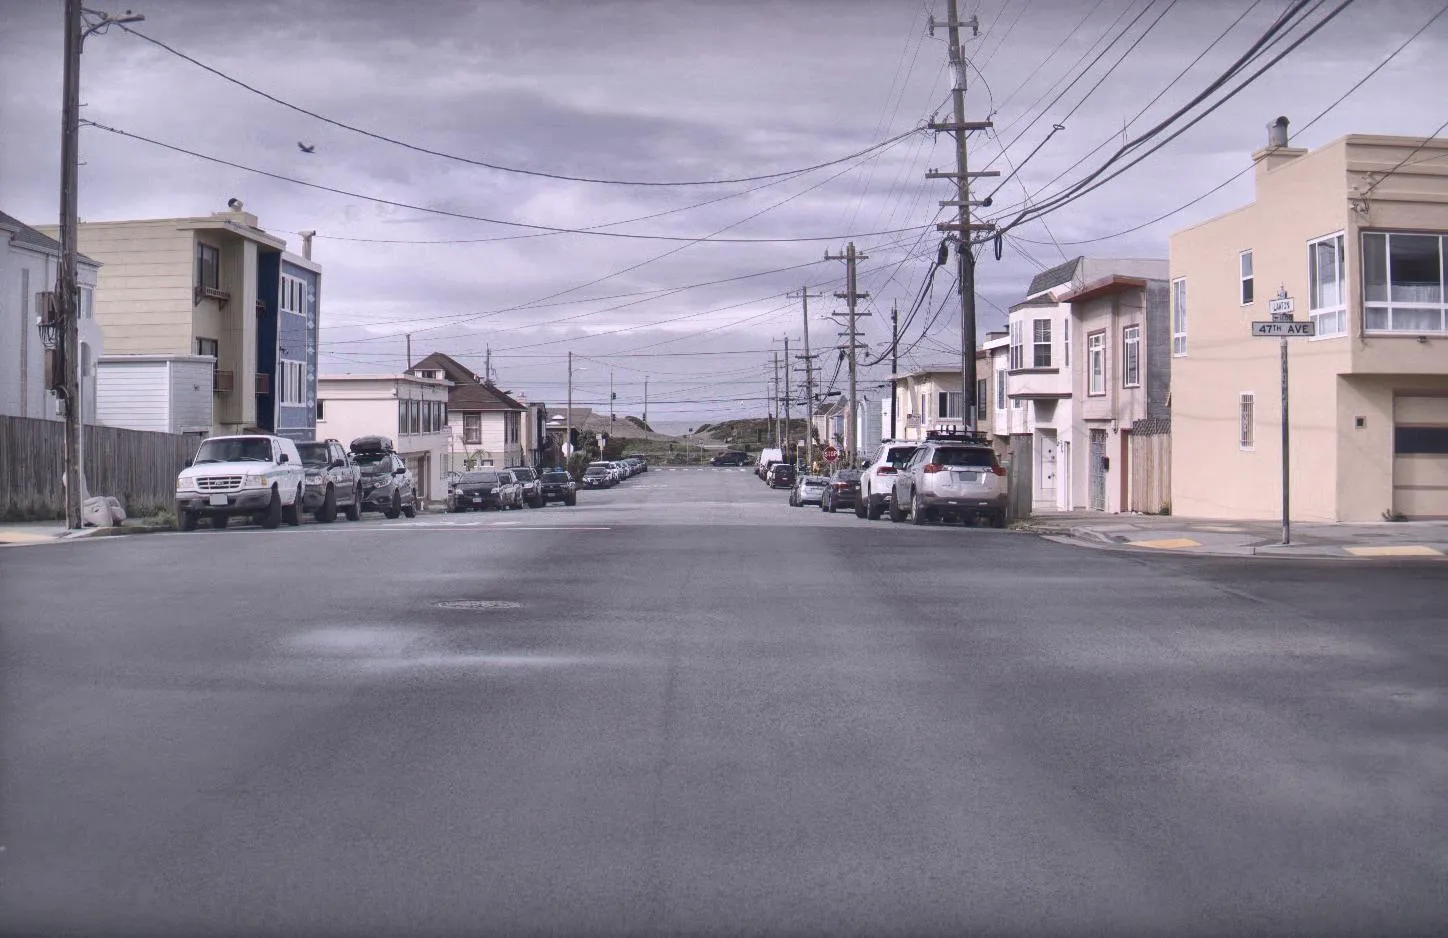

In [36]:
# view one of the images in the dataset
df.image[120]

In [37]:
# some datasets contain a field called column, we would like to call it
# input to match it to the prompt template
df.rename(columns={"question": "input"}, inplace=True)
df.head()

,input,answer,image
0,In which direction is the front wheel of the c...,C,<PIL.WebPImagePlugin.WebPImageFile image mode=...
1,How many bars are here?\nA. There are two para...,B,<PIL.WebPImagePlugin.WebPImageFile image mode=...
2,how many pedestrians are there?\nPlease answer...,0,<PIL.WebPImagePlugin.WebPImageFile image mode=...
3,"Is the road that the vehicle is on uphill, dow...",Downhill,<PIL.WebPImagePlugin.WebPImageFile image mode=...
4,What is the speed limit on this road?\n\nA. 25...,B,<PIL.WebPImagePlugin.WebPImageFile image mode=...


In [41]:
import io
import json
from PIL import Image

class PILImageEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, Image.Image):
            buffered = io.BytesIO()
            obj.save(buffered, format="JPEG")
            hex_data = buffered.getvalue().hex()
            return {
                'hex_data': hex_data,
                'format': 'JPEG'
            }
        return super(PILImageEncoder, self).default(obj)

### Subset the data

In [42]:
print(f"dataset shape before random subset = {df.shape}")
df = df.sample(n=ds_N)
print(f"dataset shape before random subset = {df.shape}")

dataset shape before random subset = (250, 3)
dataset shape before random subset = (250, 3)


Convert to json lines format

In [43]:
# if the image column is provided in the dataset, then use the PIL image encoder
if config['datasets'].get('image_col') is not None:
    logger.info(f"The data is multimodal. Using the PILImageEncoder to encode the PIL image into jsonl files")
    jsonl_content = df.to_json(orient='records', lines=True, default_handler=PILImageEncoder().default)
else:
    logger.info(f"The data is standard text data, will convert to jsonl files.")
    jsonl_content = df.to_json(orient='records', lines=True)
print(jsonl_content[:1000])

{"input":"Which is closer to us, the grey or the blue car?\nPlease answer directly with a single word or number.","answer":"Blue","image":{"hex_data":"ffd8ffe000104a46494600010100000100010000ffdb004300080606070605080707070909080a0c140d0c0b0b0c1912130f141d1a1f1e1d1a1c1c20242e2720222c231c1c2837292c30313434341f27393d38323c2e333432ffdb0043010909090c0b0c180d0d1832211c213232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232323232ffc000110803aa05a803012200021101031101ffc4001f0000010501010101010100000000000000000102030405060708090a0bffc400b5100002010303020403050504040000017d01020300041105122131410613516107227114328191a1082342b1c11552d1f02433627282090a161718191a25262728292a3435363738393a434445464748494a535455565758595a636465666768696a737475767778797a838485868788898a92939495969798999aa2a3a4a5a6a7a8a9aab2b3b4b5b6b7b8b9bac2c3c4c5c6c7c8c9cad2d3d4d5d6d7d8d9dae1e2e3e4e5e6e7e8e9eaf1f2f3f4f5f6f7f8f9faffc4001f0100030101010101010101010000000000000102030405060708090

## Upload the dataset to s3

In [44]:
bucket: str = config['s3_read_data']['read_bucket']
prefix: str = config['s3_read_data']['source_data_prefix']
file_name: str = f"{ds_id}.jsonl"
write_to_s3(jsonl_content, bucket, prefix, "", file_name)

's3://sagemaker-fmbench-read-us-west-2-988564344122/source_data/nirajandhakal/realworldqa.jsonl'

## Create a prompt template and upload it to S3
The prompt template is specific to the model under test and also the dataset being used. The variables used in the template, such as `context` and `input` must exist in the dataset being used so that this prompt template can be converted into an actual prompt.

In [19]:
# dictionary containing the prompt template, it has a key by the name
# of the dataset id which forces you to explicitly add your dataset here
# otherwise no new prompt template will be uploaded and it wont accidently
# end up overwriting an existing prompt template
prompt_template = {}

In [130]:
# LongBench
prompt_template['THUDM-LongBench-llama2-mistral'] = """<s>[INST] <<SYS>>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context in the section demarcated by "```" to answer the question. If you don't know the answer just say that you don't know. Use three sentences maximum and keep the answer concise.
<</SYS>>

```
{context}
```

Question: {input}

[/INST]
Answer:
"""

In [ ]:
# Open Orca
prompt_template['Open-Orca-OpenOrca-llama2-mistral'] = """<s>[INST] <<SYS>>

{system_prompt}

<</SYS>>

Context and task: {input}

[/INST]
"""

In [ ]:
prompt_template['Open-Orca-OpenOrca-llama3'] = """<|begin_of_text|><|start_header_id|>user<|end_header_id|>

{system_prompt}

Context and task: {input} 

<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

In [ ]:
bucket: str = config['s3_read_data']['read_bucket']
prefix: str = config['s3_read_data']['prompt_template_dir']
for k in prompt_template.keys():
    file_name: str = f"prompt_template_{k}.txt"
    print(f"writing {file_name} to s3://{bucket}/{prefix}/{file_name}")
    write_to_s3(prompt_template[k], bucket, prefix, "", file_name)

## Scratchpad

### Utility function for converting a line from container log to JSON format

The following is a line from CW log from a model container that provides all the information about the model that is not available anywhere else (not in Model or EndpointConfig or Endpoint description). This information is often necessary to know the low level settings about the model which may have been set while compiling the model.

In [3]:
line="""model_id_or_path='/tmp/.djl.ai/download/ae03dd100c208acd82b5dbed563c971de864c408' rolling_batch=<RollingBatchEnum.auto: 'auto'> tensor_parallel_degree=8 trust_remote_code=False enable_streaming=<StreamingEnum.false: 'false'> batch_size=4 max_rolling_batch_size=4 dtype=<Dtype.f16: 'fp16'> revision=None output_formatter=None waiting_steps=None is_mpi=False draft_model_id=None spec_length=0 neuron_optimize_level=None enable_mixed_precision_accumulation=False enable_saturate_infinity=False n_positions=4096 unroll=None load_in_8bit=False low_cpu_mem_usage=False load_split_model=True context_length_estimate=None amp='f16' quantize=None compiled_graph_path=None task=None save_mp_checkpoint_path=None group_query_attention=None model_loader=<TnXModelLoaders.tnx: 'tnx'> rolling_batch_strategy=<TnXGenerationStrategy.continuous_batching: 'continuous_batching'> fuse_qkv=False on_device_embedding=False attention_layout=None collectives_layout=None cache_layout=None partition_schema=None all_reduce_dtype=None cast_logits_dtype=None"""
import re
import json
pattern = r' (?=[^\'"])'


# Split the string using the pattern
result = re.split(pattern, line)
print("\n".join([r for r in result]))
params= {}
for kv in result:
    #print(kv.split('='))
    k,v = kv.split('=')
    params[k] = v
print(json.dumps(params, indent=2, default=str))

model_id_or_path='/tmp/.djl.ai/download/ae03dd100c208acd82b5dbed563c971de864c408'
rolling_batch=<RollingBatchEnum.auto: 'auto'>
tensor_parallel_degree=8
trust_remote_code=False
enable_streaming=<StreamingEnum.false: 'false'>
batch_size=4
max_rolling_batch_size=4
dtype=<Dtype.f16: 'fp16'>
revision=None
output_formatter=None
waiting_steps=None
is_mpi=False
draft_model_id=None
spec_length=0
neuron_optimize_level=None
enable_mixed_precision_accumulation=False
enable_saturate_infinity=False
n_positions=4096
unroll=None
load_in_8bit=False
low_cpu_mem_usage=False
load_split_model=True
context_length_estimate=None
amp='f16'
quantize=None
compiled_graph_path=None
task=None
save_mp_checkpoint_path=None
group_query_attention=None
model_loader=<TnXModelLoaders.tnx: 'tnx'>
rolling_batch_strategy=<TnXGenerationStrategy.continuous_batching: 'continuous_batching'>
fuse_qkv=False
on_device_embedding=False
attention_layout=None
collectives_layout=None
cache_layout=None
partition_schema=None
all_reduce_d